In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rc('font', family='Malgun Gothic')
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
def seed_setting(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_setting(42)

In [3]:
train = pd.read_csv('dts/train.csv').drop('id', axis=1)
test = pd.read_csv('dts/test.csv').drop('id', axis=1)
submission = pd.read_csv('dts/sample_submission.csv')

In [4]:
display(train.head())
print(train.info())
display(train.describe(include='all'))

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             74051 non-null  object 
 1   Length          74051 non-null  float64
 2   Diameter        74051 non-null  float64
 3   Height          74051 non-null  float64
 4   Weight          74051 non-null  float64
 5   Shucked Weight  74051 non-null  float64
 6   Viscera Weight  74051 non-null  float64
 7   Shell Weight    74051 non-null  float64
 8   Age             74051 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 5.1+ MB
None


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,27084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,NaN,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,NaN,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,NaN,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,NaN,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,NaN,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000


<Axes: >

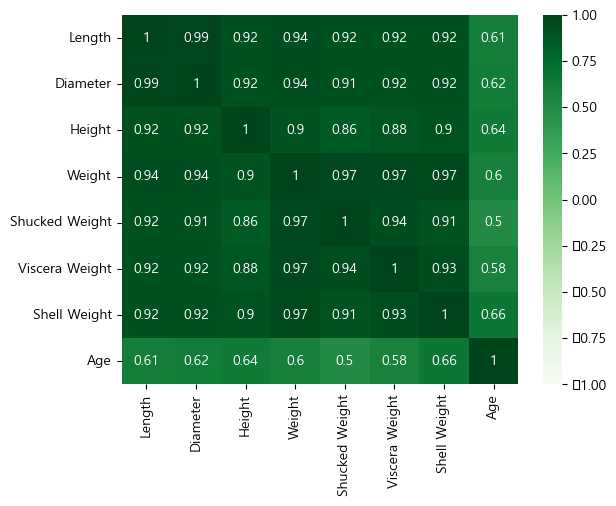

In [5]:
sns.heatmap(train.drop('Sex',axis=1).corr(), annot=True, vmin=-1, vmax=1, cmap='Greens')

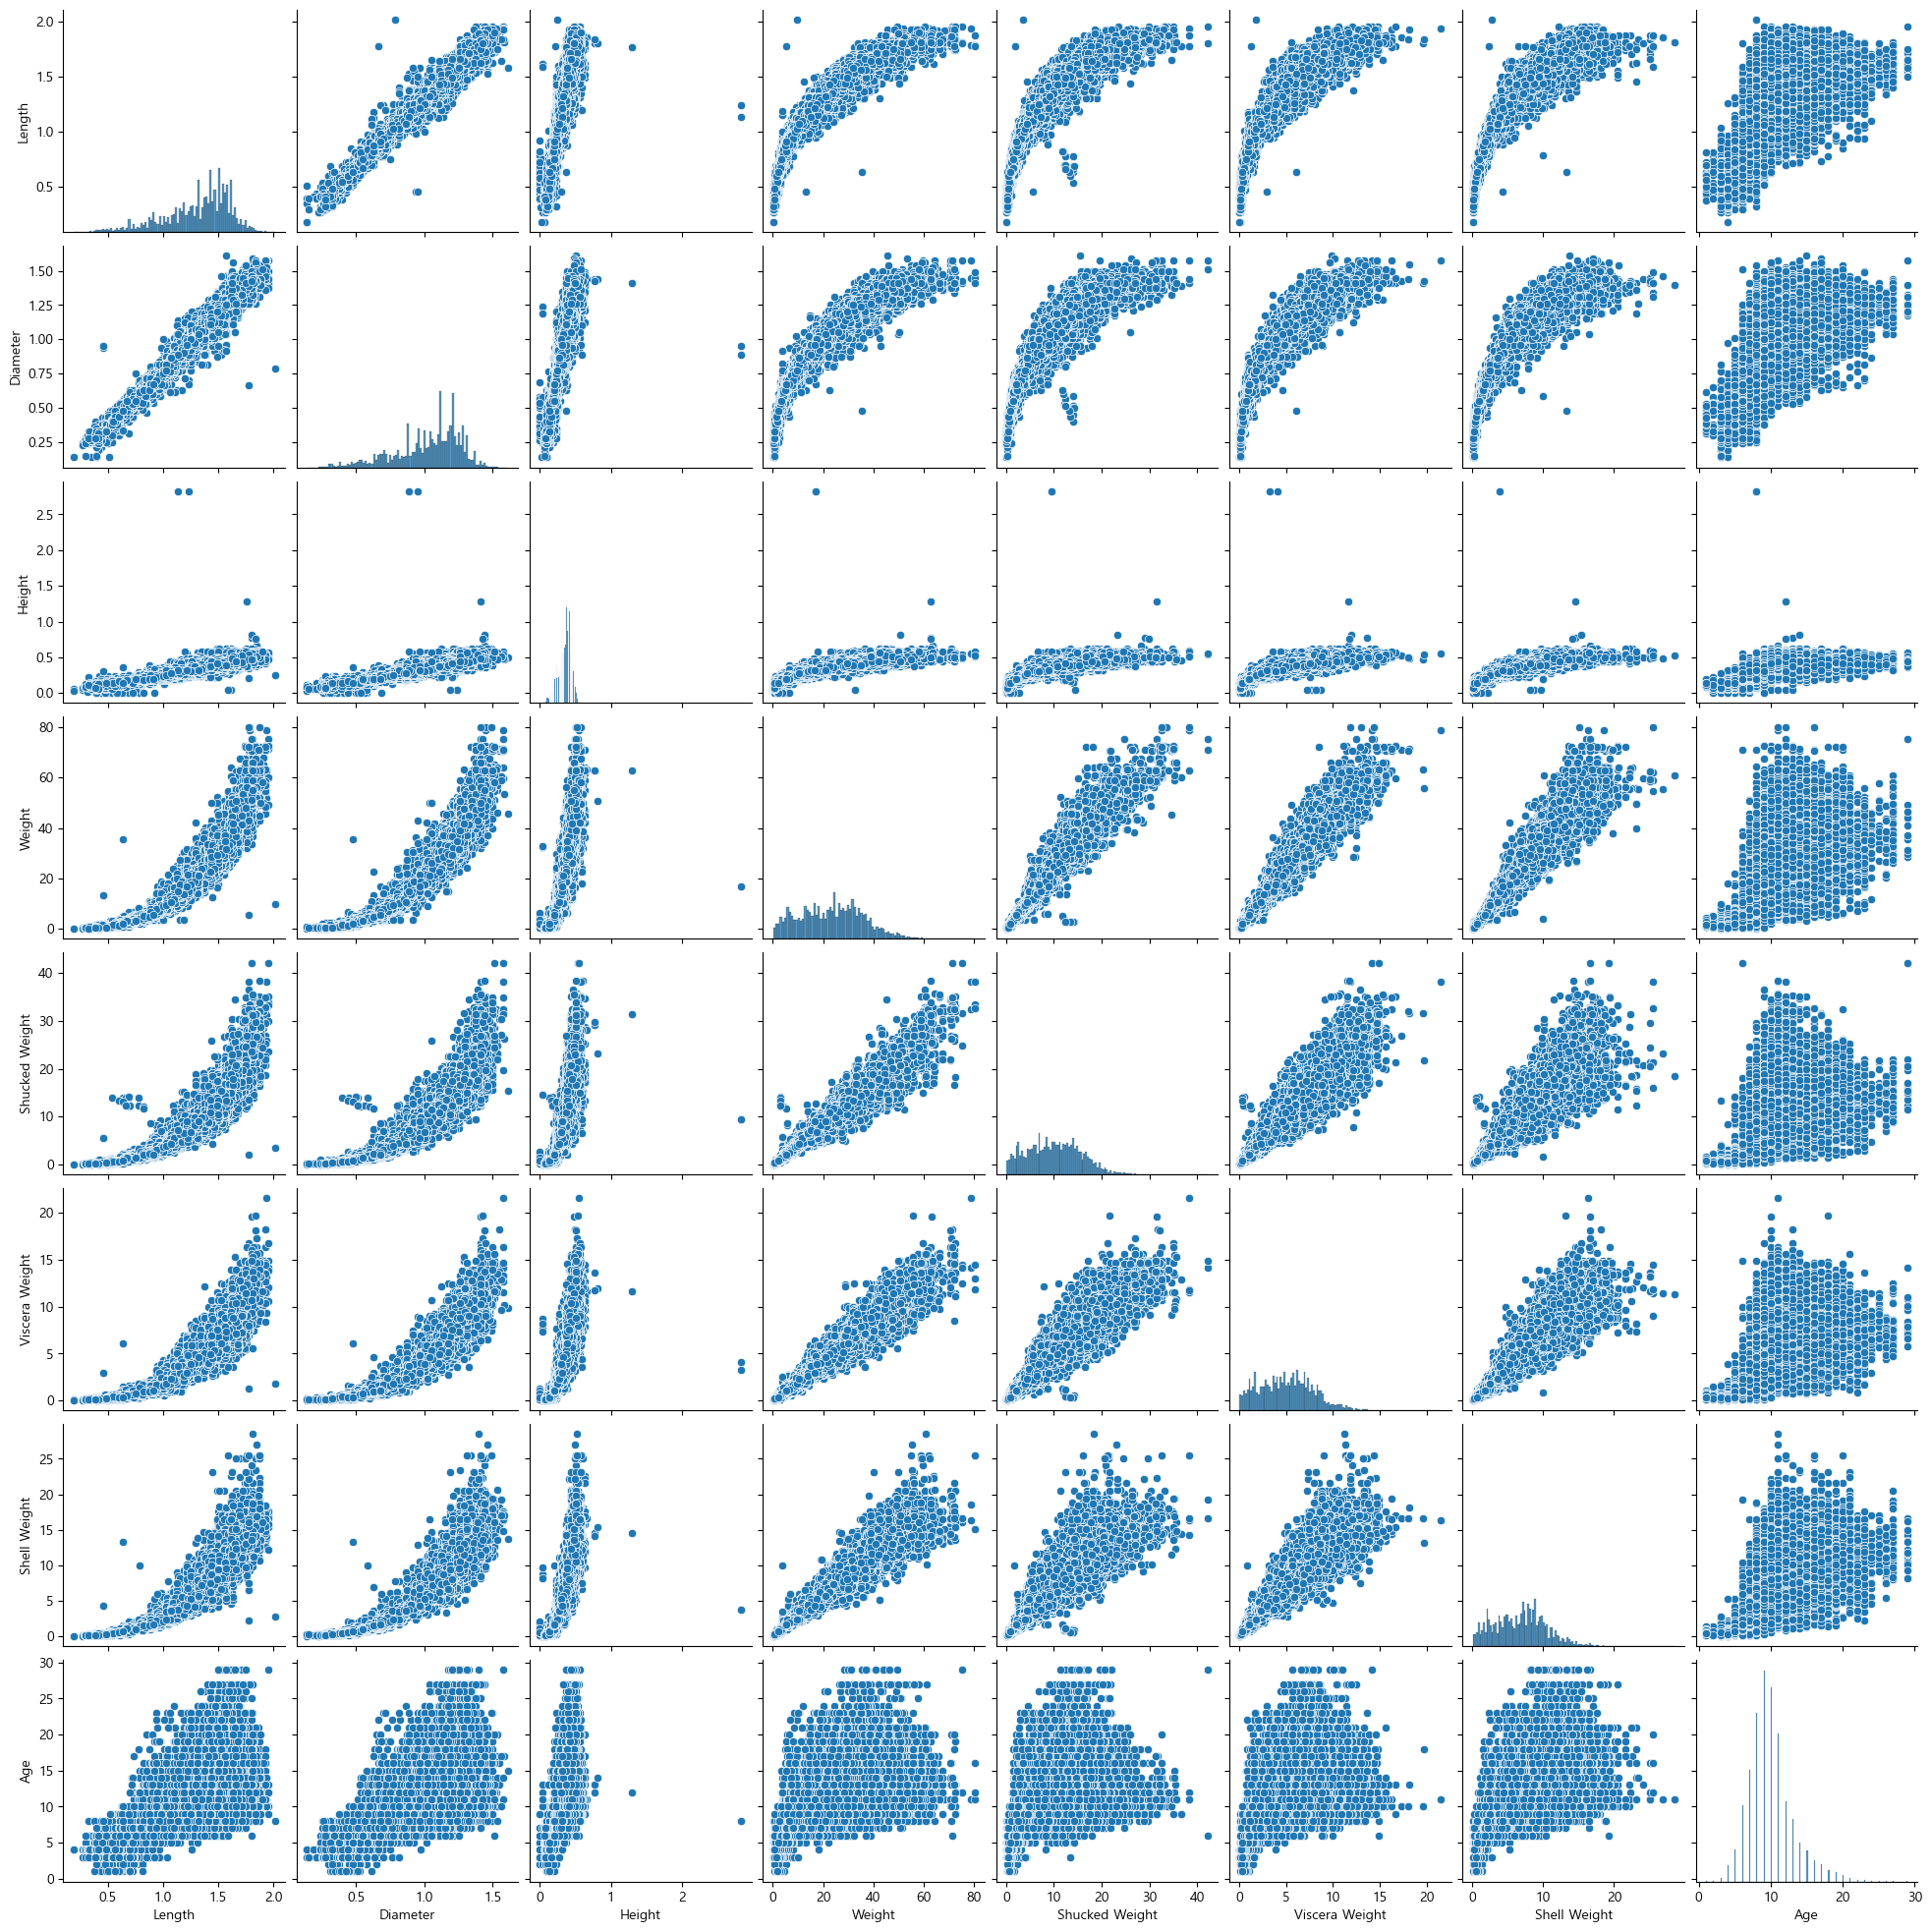

In [15]:
sns.pairplot(train)

<Axes: >

<Figure size 1000x1000 with 0 Axes>

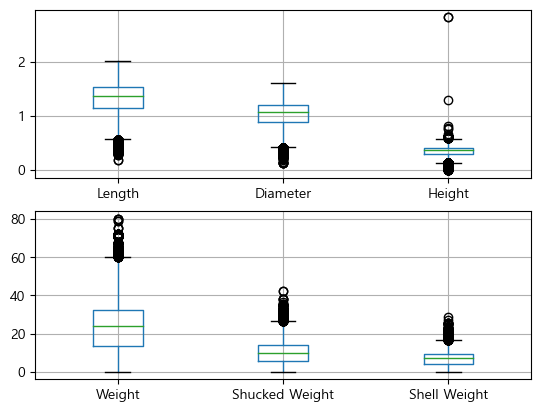

In [6]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(2,1)
plt.subplot(2,1,1)
train.boxplot(column=['Length','Diameter','Height'])
plt.subplot(2,1,2)
train.boxplot(column=['Weight','Shucked Weight','Shell Weight'])

## preprocessing

In [7]:
# 1. Sex -> 원-핫 인코딩
from sklearn.preprocessing import OneHotEncoder as ohe

encoder = ohe(sparse=False)
encoder.fit(train[['Sex']])

train = pd.concat([train, pd.DataFrame(encoder.transform(train[['Sex']]), columns=encoder.categories_[0])], axis=1).drop('Sex',axis=1)
test = pd.concat([test, pd.DataFrame(encoder.transform(test[['Sex']]), columns=encoder.categories_[0])], axis=1).drop('Sex',axis=1)

In [8]:
# 2. 이상치 제거
train['Height'].describe()

count    74051.000000
mean         0.348089
std          0.092034
min          0.000000
25%          0.300000
50%          0.362500
75%          0.412500
max          2.825000
Name: Height, dtype: float64

In [9]:
def outlier(df, col_name):
    values = []

    Q1 = np.percentile(df[col_name],25)
    Q3 = np.percentile(df[col_name],75)
    IQR = Q3 - Q1

    outlier_step = IQR * 1.5

    for val in df[col_name]:
        if val > Q3 + outlier_step:
            val = Q3 + outlier_step
        elif val < Q1 - outlier_step:
            val = Q1 - outlier_step
        values.append(val)

    return values

In [10]:
train['Height'] = outlier(train, 'Height')

In [11]:
train_x = train.drop('Age',axis=1)
train_y = train['Age']

## modeling

In [12]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error as mae

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=.2, random_state=42)

In [15]:
logistic = LogisticRegression(random_state=42, penalty=None, solver='newton-cg')
linear = LinearRegression(positive=False)
lasso = Lasso(random_state=42, alpha=.5, positive=False, selection='random')
ridge = Ridge(random_state=42, alpha=1, positive=False)
elastic = ElasticNet(random_state=42, alpha=.5, l1_ratio=.3, positive=False, selection='cyclic')

logistic.fit(x_train, y_train)
linear.fit(x_train, y_train)
lasso.fit(x_train, y_train)
ridge.fit(x_train, y_train)
elastic.fit(x_train, y_train)

print('-'*20)
print('logistic : ', mae(y_val, logistic.predict(x_val)))
print('-'*20)
print('linear : ', mae(y_val, linear.predict(x_val)))
print('-'*20)
print('lasso : ', mae(y_val, lasso.predict(x_val)))
print('-'*20)
print('ridge : ', mae(y_val, ridge.predict(x_val)))
print('-'*20)
print('elastic : ', mae(y_val, elastic.predict(x_val)))
print('-'*20)

--------------------
logistic :  1.452839106069813
--------------------
linear :  1.4894485784525178
--------------------
lasso :  1.6232511217996393
--------------------
ridge :  1.4893890161500851
--------------------
elastic :  1.5838564146485101
--------------------


In [95]:
lgbm = LGBMRegressor(objective='mae', application='regression', random_state=42, n_estimators=1500, max_depth=5, learning_rate=.1)
lgbm.fit(x_train, y_train, eval_metric='MAE', eval_set=[(x_train, y_train), (x_val,y_val)], verbose=100)

xgb = XGBRegressor(objective='reg:absoluteerror', random_state=42, n_estimators=360, max_depth=5, learning_rate=.1)
xgb.fit(x_train, y_train, eval_metric='mae', eval_set=[(x_train, y_train), (x_val,y_val)], verbose=30)

cat = CatBoostRegressor(eval_metric='MAE', use_best_model=True, random_state=42, learning_rate=.1, max_depth=5, grow_policy='Lossguide', subsample=.8, reg_lambda=4)
cat.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val,y_val)], verbose=100)

[100]	training's l1: 1.34939	valid_1's l1: 1.37149
[200]	training's l1: 1.33912	valid_1's l1: 1.36719
[300]	training's l1: 1.33191	valid_1's l1: 1.36421
[400]	training's l1: 1.32622	valid_1's l1: 1.36177
[500]	training's l1: 1.32021	valid_1's l1: 1.35936
[600]	training's l1: 1.31808	valid_1's l1: 1.35911
[700]	training's l1: 1.31493	valid_1's l1: 1.35825
[800]	training's l1: 1.31192	valid_1's l1: 1.35796
[900]	training's l1: 1.30987	valid_1's l1: 1.35768
[1000]	training's l1: 1.30795	valid_1's l1: 1.35738
[1100]	training's l1: 1.30742	valid_1's l1: 1.35744
[1200]	training's l1: 1.30705	valid_1's l1: 1.3574
[1300]	training's l1: 1.30679	valid_1's l1: 1.35747
[1400]	training's l1: 1.30378	valid_1's l1: 1.3567
[1500]	training's l1: 1.30292	valid_1's l1: 1.35662
[0]	validation_0-mae:2.28486	validation_1-mae:2.30890
[30]	validation_0-mae:1.57024	validation_1-mae:1.58417
[60]	validation_0-mae:1.41402	validation_1-mae:1.43202
[90]	validation_0-mae:1.37794	validation_1-mae:1.40257
[120]	valida

In [96]:
print('-'*20)
print('lgbm : ', mae(y_val, lgbm.predict(x_val)))
print('-'*20)
print('xgb : ', mae(y_val, xgb.predict(x_val)))
print('-'*20)
print('cat : ', mae(y_val, cat.predict(x_val)))
print('-'*20)

--------------------
lgbm :  1.3566242249026168
--------------------
xgb :  1.369724240021979
--------------------
cat :  1.4024957929821418
--------------------


In [100]:
lg = 1.3566242249026168
xg = 1.369724240021979
ca = 1.4024957929821418

print(lg/lg+xg+ca)
print(xg/lg+xg+ca)
print(ca/lg+xg+ca)

3.7722200330041207
3.7818763658919567
3.806033057449278


In [125]:
from sklearn.ensemble import VotingRegressor, BaggingRegressor
cat2 = CatBoostRegressor(eval_metric='MAE', random_state=42, learning_rate=.1, max_depth=5, grow_policy='Lossguide', subsample=.8, reg_lambda=4, iterations=252)

voting = VotingRegressor([('lgbm',lgbm), ('xgb',xgb), ('cat',cat2)], weights=[.5,.3,.2])
voting.fit(x_train, y_train)

0:	learn: 2.2003604	total: 8.37ms	remaining: 2.1s
1:	learn: 2.0967810	total: 15.5ms	remaining: 1.94s
2:	learn: 2.0056087	total: 23.1ms	remaining: 1.92s
3:	learn: 1.9247513	total: 30.1ms	remaining: 1.86s
4:	learn: 1.8567128	total: 37.2ms	remaining: 1.84s
5:	learn: 1.7966335	total: 44.1ms	remaining: 1.81s
6:	learn: 1.7451422	total: 51.4ms	remaining: 1.8s
7:	learn: 1.7014629	total: 58.2ms	remaining: 1.77s
8:	learn: 1.6642130	total: 65.4ms	remaining: 1.76s
9:	learn: 1.6326285	total: 72.4ms	remaining: 1.75s
10:	learn: 1.6050745	total: 79.3ms	remaining: 1.74s
11:	learn: 1.5808454	total: 86.3ms	remaining: 1.73s
12:	learn: 1.5605819	total: 92.7ms	remaining: 1.7s
13:	learn: 1.5421521	total: 99.5ms	remaining: 1.69s
14:	learn: 1.5264874	total: 106ms	remaining: 1.68s
15:	learn: 1.5124402	total: 113ms	remaining: 1.66s
16:	learn: 1.5008309	total: 119ms	remaining: 1.64s
17:	learn: 1.4909067	total: 126ms	remaining: 1.64s
18:	learn: 1.4817664	total: 132ms	remaining: 1.62s
19:	learn: 1.4731574	total: 13

VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(application='regression',
                                           max_depth=5, n_estimators=1500,
                                           objective='mae', random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_typ...
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=360, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:absoluteerror',
                                          predictor=None, ...)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x000001BD4A441F60>)],
                weights=[0.5, 0.3, 0.2])

In [105]:
lgbm = LGBMRegressor(objective='mae', application='regression', random_state=42, n_estimators=1500, max_depth=5, learning_rate=.1)
lgbm.fit(train_x, train_y)

LGBMRegressor(application='regression', max_depth=5, n_estimators=1500,
              objective='mae', random_state=42)

In [123]:
submission['Age'] = np.round(lgbm.predict(test))


In [124]:
submission.to_csv('lgbm_new_round.csv',index=False)

In [112]:
np.round(voting.predict(x_val),2)

array([14.,  5., 10., ..., 11.,  6., 10.])

In [122]:
print('cat : ', mae(y_val, np.round(lgbm.predict(x_val))))

cat :  1.2945108365404092


In [137]:
print('cat : ', mae(y_val, np.round(voting.predict(x_val))))

cat :  1.3417730065491864


In [83]:
import time

# linear_model
logistic = LogisticRegression(random_state=42)
linear = LinearRegression()
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
elastic = ElasticNet(random_state=42)

param_logistic = {
    'penalty' : ['l1','l2','elasticnet',None],
    'solver' : ['newton-cholesky','newton-cg','liblinear','sag','saga','lbfgs']
}
param_linear = {
    'positive' : [True, False]
}
param_lasso = {
    'alpha' : [.5, 1],
    'positive' : [True, False],
    'selection' : ['cyclic', 'random']
}
param_ridge = {
    'alpha' : [.5, 1],
    'positive' : [True, False],
}
param_elastic = {
    'alpha' : [.5, 1],
    'l1_ratio' : [.3,.5,.7],
    'positive' : [True, False],
    'selection':['cyclic','random']
}

grid_logistic = GridSearchCV(estimator=logistic, param_grid=param_logistic, scoring='neg_mean_absolute_error', cv=3, refit=True)
grid_linear = GridSearchCV(estimator=linear, param_grid=param_linear, scoring='neg_mean_absolute_error', cv=3, refit=True)
grid_lasso = GridSearchCV(estimator=lasso, param_grid=param_lasso, scoring='neg_mean_absolute_error', cv=3, refit=True)
grid_ridge = GridSearchCV(estimator=ridge, param_grid=param_ridge, scoring='neg_mean_absolute_error', cv=3, refit=True)
grid_elastic = GridSearchCV(estimator=elastic, param_grid=param_elastic, scoring='neg_mean_absolute_error', cv=3, refit=True)

start = time.time()
grid_logistic.fit(train_x,train_y)
end = time.time()
print(f"logistic {end - start:.5f} sec")

start = time.time()
grid_linear.fit(train_x,train_y)
end = time.time()
print(f"linear {end - start:.5f} sec")

start = time.time()
grid_lasso.fit(train_x,train_y)
end = time.time()
print(f"lasso {end - start:.5f} sec")

start = time.time()
grid_ridge.fit(train_x,train_y)
end = time.time()
print(f"ridge {end - start:.5f} sec")

start = time.time()
grid_elastic.fit(train_x,train_y)
end = time.time()
print(f"elastic {end - start:.5f} sec")

logistic 1656.92027 sec
linear 0.10844 sec
lasso 5.34183 sec
ridge 0.11400 sec
elastic 13.62634 sec


In [84]:
print("="*30)
print('logistic reg 파라미터: ', grid_logistic.best_params_)
print('logistic reg 예측 MAE: {:.4f}'.format(grid_logistic.best_score_))
print("="*30)
print('linear 파라미터: ', grid_linear.best_params_)
print('linear 예측 MAE: {:.4f}'.format(grid_linear.best_score_))
print("="*30)
print('lasso 파라미터: ', grid_lasso.best_params_)
print('lasso 예측 MAE: {:.4f}'.format(grid_lasso.best_score_))
print("="*30)
print('ridge 파라미터: ', grid_ridge.best_params_)
print('ridge 예측 MAE: {:.4f}'.format(grid_ridge.best_score_))
print("="*30)
print('elastic 파라미터: ', grid_elastic.best_params_)
print('elastic 예측 MAE: {:.4f}'.format(grid_elastic.best_score_))
print("="*30)

logistic reg 파라미터:  {'penalty': None, 'solver': 'newton-cg'}
logistic reg 예측 MAE: -1.4529
linear 파라미터:  {'positive': False}
linear 예측 MAE: -1.4830
lasso 파라미터:  {'alpha': 0.5, 'positive': False, 'selection': 'random'}
lasso 예측 MAE: -1.6128
ridge 파라미터:  {'alpha': 1, 'positive': False}
ridge 예측 MAE: -1.4829
elastic 파라미터:  {'alpha': 0.5, 'l1_ratio': 0.3, 'positive': False, 'selection': 'cyclic'}
elastic 예측 MAE: -1.5742


In [85]:
# tree & ensemble model
tree = DecisionTreeRegressor(criterion='absolute_error', random_state=42)
rfc = RandomForestRegressor(criterion='absolute_error', random_state=42)
lgbm = LGBMRegressor(application='regression', objective='mae', random_state=42)
xgb = XGBRegressor(objective='reg:absoluteerror', random_state=42)
cat = CatBoostRegressor(eval_metric='MAE', use_best_model=True, random_state=42)

param_tree = {
    'splitter':['best','random'],
    'max_depth':[4,6,8]
}
param_rfc = {
    'n_estimators':[100,300],
    'max_depth':[4,6,8]
}
param_lgbm = {
    'n_estimators':[100,300],
    'boosting':['gdbt','rf','dart','goss'],
    'max_depth':[4,6,8]  
}
param_xgb = {
    'booster':['gbtree','gblinear','dart'],
    'n_estimators':[100,300],
    'max_depth':[4,6,8],
}
param_cat = {
    'n_estimators':[100,300],
    'depth':[3,5,7,9],
    'grow_policy' : ['SymmetricTree','Lossguide','Depthwise']
}

grid_tree = GridSearchCV(estimator=tree, param_grid=param_tree, scoring='neg_mean_absolute_error', cv=3, refit=True)
grid_rfc = GridSearchCV(estimator=rfc, param_grid=param_rfc, scoring='neg_mean_absolute_error', cv=3, refit=True)
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_lgbm, scoring='neg_mean_absolute_error', cv=3, refit=True)
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_xgb, scoring='neg_mean_absolute_error', cv=3, refit=True)
grid_cat = GridSearchCV(estimator=cat, param_grid=param_cat, scoring='neg_mean_absolute_error', cv=3, refit=True)

start = time.time()
grid_tree.fit(train_x,train_y)
end = time.time()
print(f"logistic {end - start:.5f} sec") # tree

start = time.time()
grid_rfc.fit(train_x,train_y)
end = time.time()
print(f"linear {end - start:.5f} sec") # random forest

start = time.time()
grid_lgbm.fit(train_x,train_y)
end = time.time()
print(f"lasso {end - start:.5f} sec") # lightgbm

start = time.time()
grid_xgb.fit(train_x,train_y)
end = time.time()
print(f"ridge {end - start:.5f} sec") # xgboost

start = time.time()
grid_cat.fit(train_x,train_y)
end = time.time()
print(f"elastic {end - start:.5f} sec") # catboost

logistic 755.79843 sec


KeyboardInterrupt: 

In [ ]:
print("="*30)
print('decision tree 파라미터: ', grid_tree.best_params_)
print('decision tree 예측 MAE: {:.4f}'.format(grid_tree.best_score_))
print("="*30)
print('rfc 파라미터: ', grid_rfc.best_params_)
print('rfc 예측 MAE: {:.4f}'.format(grid_rfc.best_score_))
print("="*30)
print('lgbm 파라미터: ', grid_lgbm.best_params_)
print('lgbm 예측 MAE: {:.4f}'.format(grid_lgbm.best_score_))
print("="*30)
print('xgb 파라미터: ', grid_xgb.best_params_)
print('xgb 예측 MAE: {:.4f}'.format(grid_xgb.best_score_))
print("="*30)
print('cat 파라미터: ', grid_cat.best_params_)
print('cat 예측 MAE: {:.4f}'.format(grid_cat.best_score_))
print("="*30)

In [ ]:
# neural network model
nn = MLPRegressor(early_stopping=True, validation_fraction=.2, n_iter_no_change=50, random_state=42)

param_nn = {
    'hidden_layer_sizes':[(64,),(128,),(256,)],
    'activation':['identity','logistic','tanh','relu'],
    'solver':['lbfgs','sgd','adam'],
    'learning_rate' : ['constant','invscaling','adaptive'],
    'learning_rate_init':[.03,.01,.1],
    'max_iter':[200,500]
}

grid_nn = GridSearchCV(estimator=nn, param_grid=param_nn, scoring='neg_mean_absolute_error', cv=3, refit=True)

start = time.time()
grid_nn.fit(train_x,train_y)
end = time.time()
print(f"mlp {end - start:.5f} sec")